In [0]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 24.2MB 366kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 378kB 9.4MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.25.3)


In [0]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
import sklearn as sk
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
#from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#from sklearn.manifold import TSNE
#from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
import keras
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras.models import Sequential
#from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
#from keras import utils
#from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
#from nltk.corpus import stopwords
#from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [0]:
#Google Colab Functions
from google.colab import files
upload = files.upload()

Saving testdata.manual.2009.06.14.csv to testdata.manual.2009.06.14.csv
Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon.csv


In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Import dataset and create dataframe in runtime

In [0]:
columns = ["target", "ids", "date", "flag", "user", "text"]
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'latin-1', names = columns)
train_set, test_set = sk.model_selection.train_test_split(dataset, test_size = 0.2, random_state = 456) #non-shuffle using random-state seed 456
#test_set = pd.read_csv('testdata.manual.2009.06.14.csv', encoding = 'latin-1', names = columns)

In [0]:
print('Training Dataset Size: ', len(train_set))
print('Test Dataset Size: ', len(test_set))

Training Dataset Size:  1280000
Test Dataset Size:  320000


In [0]:
%%time
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]
train_set.target = train_set.target.apply(lambda x: decode_sentiment(x))
test_set.target = test_set.target.apply(lambda x: decode_sentiment(x))

CPU times: user 495 ms, sys: 3.8 ms, total: 499 ms
Wall time: 512 ms


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [0]:
# Pre-process - Sentiment Decoded DataFrames for Training and Test
train_set.head(5)

,target,ids,date,flag,user,text
1280,NEGATIVE,1468121466,Mon Apr 06 23:49:56 PDT 2009,NO_QUERY,tominlumban,"Yo jimo i cant talk on aim anymore, its glitch..."
758478,NEGATIVE,2295754798,Tue Jun 23 08:20:04 PDT 2009,NO_QUERY,jshirley,OS X apps are frustrating me by not lining up ...
1511253,POSITIVE,2175066462,Mon Jun 15 00:00:16 PDT 2009,NO_QUERY,MyAnnoyances,Going to go to bed now.. Night. I need to fig...
853234,POSITIVE,1573132983,Mon Apr 20 23:51:12 PDT 2009,NO_QUERY,VioletAngel1,is loving this oh-so-gorgeous sunny morning.. ...
1446169,POSITIVE,2062471381,Sat Jun 06 23:19:44 PDT 2009,NO_QUERY,_kaylamarie,ohhh what a day... what a day


In [0]:
test_set.head(5)

,target,ids,date,flag,user,text
499453,NEGATIVE,2186529502,Mon Jun 15 18:58:20 PDT 2009,NO_QUERY,AlaskaPoker,Mike Kaminski didn't make it to dinner in the 2k
194455,NEGATIVE,1970293065,Sat May 30 03:15:30 PDT 2009,NO_QUERY,keren4562,"@tommcfly hi, today my sister and couse &lt;or..."
1569019,POSITIVE,2188322959,Mon Jun 15 21:41:20 PDT 2009,NO_QUERY,nany_micucci,@buckhollywood THATS what im talking aboutt!! ...
596480,NEGATIVE,2219031600,Wed Jun 17 23:39:03 PDT 2009,NO_QUERY,brittneybella,realized how sad my last posting was... Does a...
793941,NEGATIVE,2326807698,Thu Jun 25 07:32:15 PDT 2009,NO_QUERY,GracieNichols,Just woke up.. My throat hurts


In [0]:
%%time
stop_words = nltk.corpus.stopwords.words("english")
stemmer = nltk.stem.SnowballStemmer("english")
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

train_set.text = train_set.text.apply(lambda x: preprocess(x))
test_set.text = test_set.text.apply(lambda x: preprocess(x))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


CPU times: user 38.1 s, sys: 147 ms, total: 38.3 s
Wall time: 38.4 s


In [0]:
# Post-processed - Sentiment Decoded and Text Processed DataFrames
train_set.head(5)

,target,ids,date,flag,user,text
1280,NEGATIVE,1468121466,Mon Apr 06 23:49:56 PDT 2009,NO_QUERY,tominlumban,yo jimo cant talk aim anymore glitching ill cy...
758478,NEGATIVE,2295754798,Tue Jun 23 08:20:04 PDT 2009,NO_QUERY,jshirley,os x apps frustrating lining tidy arrangement ...
1511253,POSITIVE,2175066462,Mon Jun 15 00:00:16 PDT 2009,NO_QUERY,MyAnnoyances,going go bed night need figure way get subscri...
853234,POSITIVE,1573132983,Mon Apr 20 23:51:12 PDT 2009,NO_QUERY,VioletAngel1,loving oh gorgeous sunny morning great day twi...
1446169,POSITIVE,2062471381,Sat Jun 06 23:19:44 PDT 2009,NO_QUERY,_kaylamarie,ohhh day day


In [0]:
test_set.head(5)

,target,ids,date,flag,user,text
499453,NEGATIVE,2186529502,Mon Jun 15 18:58:20 PDT 2009,NO_QUERY,AlaskaPoker,mike kaminski make dinner 2k
194455,NEGATIVE,1970293065,Sat May 30 03:15:30 PDT 2009,NO_QUERY,keren4562,hi today sister couse lt amp roni gt birthday ...
1569019,POSITIVE,2188322959,Mon Jun 15 21:41:20 PDT 2009,NO_QUERY,nany_micucci,thats im talking aboutt hahhaa
596480,NEGATIVE,2219031600,Wed Jun 17 23:39:03 PDT 2009,NO_QUERY,brittneybella,realized sad last posting anyone want friend lol
793941,NEGATIVE,2326807698,Thu Jun 25 07:32:15 PDT 2009,NO_QUERY,GracieNichols,woke throat hurts


Word2Vec - Generate word embeddings for embedding layer of LSTM

In [0]:
%%time
documents = [_text.split() for _text in train_set.text] 

CPU times: user 2.88 s, sys: 356 ms, total: 3.24 s
Wall time: 3.25 s


In [0]:
print(len(documents))

1280000


In [0]:
w2v_model = gensim.models.word2vec.Word2Vec(size=160, 
                                            window=5, 
                                            min_count=10, 
                                            workers=8)

In [0]:
w2v_model.build_vocab(documents)

2019-12-08 07:03:18,889 : INFO : collecting all words and their counts
2019-12-08 07:03:18,890 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-08 07:03:18,918 : INFO : PROGRESS: at sentence #10000, processed 72327 words, keeping 14106 word types
2019-12-08 07:03:18,936 : INFO : PROGRESS: at sentence #20000, processed 144160 words, keeping 21397 word types
2019-12-08 07:03:18,960 : INFO : PROGRESS: at sentence #30000, processed 216408 words, keeping 27464 word types
2019-12-08 07:03:18,980 : INFO : PROGRESS: at sentence #40000, processed 288821 words, keeping 32900 word types
2019-12-08 07:03:18,998 : INFO : PROGRESS: at sentence #50000, processed 360337 words, keeping 37687 word types
2019-12-08 07:03:19,019 : INFO : PROGRESS: at sentence #60000, processed 432591 words, keeping 42176 word types
2019-12-08 07:03:19,040 : INFO : PROGRESS: at sentence #70000, processed 504923 words, keeping 46272 word types
2019-12-08 07:03:19,059 : INFO : PROGRESS: at s

In [0]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30368


In [0]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=15)

2019-12-08 07:03:38,155 : INFO : training model with 8 workers on 30368 vocabulary and 160 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2019-12-08 07:03:39,171 : INFO : EPOCH 1 - PROGRESS: at 6.39% examples, 525061 words/s, in_qsize 16, out_qsize 1
2019-12-08 07:03:40,203 : INFO : EPOCH 1 - PROGRESS: at 13.54% examples, 547605 words/s, in_qsize 11, out_qsize 4
2019-12-08 07:03:41,227 : INFO : EPOCH 1 - PROGRESS: at 20.81% examples, 559447 words/s, in_qsize 14, out_qsize 1
2019-12-08 07:03:42,241 : INFO : EPOCH 1 - PROGRESS: at 28.49% examples, 575400 words/s, in_qsize 13, out_qsize 2
2019-12-08 07:03:43,320 : INFO : EPOCH 1 - PROGRESS: at 35.96% examples, 574239 words/s, in_qsize 15, out_qsize 0
2019-12-08 07:03:44,345 : INFO : EPOCH 1 - PROGRESS: at 43.02% examples, 572817 words/s, in_qsize 14, out_qsize 5
2019-12-08 07:03:45,355 : INFO : EPOCH 1 - PROGRESS: at 49.83% examples, 570235 words/s, in_qsize 15, out_qsize 0
2019-12-08 07:03:46,369 : INFO : EPOCH 1 - PROGRESS: 

CPU times: user 6min 27s, sys: 1.65 s, total: 6min 28s
Wall time: 3min 22s


(123395890, 138482550)

In [0]:
# Verify word2vec
w2v_model.most_similar("hello")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-12-08 07:08:25,009 : INFO : precomputing L2-norms of word weight vectors


[('hi', 0.7569838166236877),
 ('hola', 0.6420450210571289),
 ('howdy', 0.6044795513153076),
 ('welcome', 0.566409707069397),
 ('goodmorning', 0.5332635045051575),
 ('hiya', 0.5290366411209106),
 ('hallo', 0.5270193815231323),
 ('ello', 0.5037354230880737),
 ('hey', 0.49167829751968384),
 ('hellos', 0.4870837926864624)]

In [0]:
w2v_model.most_similar("world")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('earth', 0.5478287935256958),
 ('worlds', 0.5417398810386658),
 ('life', 0.46506989002227783),
 ('twitterverse', 0.4473865032196045),
 ('planet', 0.41684821248054504),
 ('europe', 0.39751800894737244),
 ('nation', 0.3722932040691376),
 ('universe', 0.35701149702072144),
 ('thing', 0.3547739088535309),
 ('country', 0.3524349331855774)]

In [0]:
%%time
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_set.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 291132
CPU times: user 17.1 s, sys: 75.6 ms, total: 17.1 s
Wall time: 17.2 s


In [0]:
%%time
x_train = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(train_set.text), maxlen=280) #Standardize Text input for model training
x_test = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(test_set.text), maxlen=280) #Standardize Text input for test evaluation
print('x_train', x_train.shape)
print('x_test', x_test.shape)

x_train (1280000, 280)
x_test (320000, 280)
CPU times: user 25 s, sys: 432 ms, total: 25.4 s
Wall time: 25.4 s


In [0]:
labels = train_set.target.unique().tolist()
labels.append('NEUTRAL')
labels

#Encode Labels
encoder = sk.preprocessing.LabelEncoder()
encoder.fit(train_set.target.tolist())

y_train = encoder.transform(train_set.target.tolist())
y_test = encoder.transform(test_set.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [0]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 280)
y_train (1280000, 1)

x_test (320000, 280)
y_test (320000, 1)


In [0]:
# Create the embedding layer
embedding_matrix = np.zeros((vocab_size, 160))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(291132, 160)


In [0]:
embedding_layer = keras.layers.Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [0]:
# Create the LSTM RNN model
model = keras.models.Sequential()
#model.add(embedding_layer)
#model.add(keras.layers.Dropout(0.5))
#model.add(keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#model.add(keras.layers.Dense(1, activation='sigmoid'))


 model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=3,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2019-12-08 07:14:43,274 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
files.download('model_plot.png')

In [0]:
model.summary()
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 280, 160)          46581120  
_________________________________________________________________
dropout_1 (Dropout)          (None, 280, 160)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               104400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 46,685,621
Trainable params: 104,501
Non-trainable params: 46,581,120
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-12-08 07:15:59,246 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
callbacks = [ keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [0]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=512,
                    epochs=15,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

2019-12-08 07:16:37,017 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 1152000 samples, validate on 128000 samples
Epoch 1/15
1152000/1152000 [==============================] - 606s 526us/step - loss: 0.5122 - accuracy: 0.7442 - val_loss: 0.4671 - val_accuracy: 0.7760
Epoch 2/15
1152000/1152000 [==============================] - 606s 526us/step - loss: 0.4918 - accuracy: 0.7590 - val_loss: 0.4593 - val_accuracy: 0.7803
Epoch 3/15
1152000/1152000 [==============================] - 568s 493us/step - loss: 0.4918 - accuracy: 0.7585 - val_loss: 0.4650 - val_accuracy: 0.7773
Epoch 4/15
1152000/1152000 [==============================] - 557s 483us/step - loss: 0.4907 - accuracy: 0.7597 - val_loss: 0.4576 - val_accuracy: 0.7816
Epoch 5/15
1152000/1152000 [==============================] - 564s 489us/step - loss: 0.4851 - accuracy: 0.7628 - val_loss: 0.4557 - val_accuracy: 0.7831
Epoch 6/15
1152000/1152000 [==============================] - 561s 487us/step - loss: 0.4822 - accuracy: 0.7653 - val_loss: 0.4542 - val_accuracy: 0.7832
Epoch 7/15
1152000/1152

In [0]:
%%time
score = model.evaluate(x_test, y_test, batch_size=512)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 72s 226us/step

ACCURACY: 0.7875000238418579
LOSS: 0.44996393785476685
CPU times: user 1min 39s, sys: 7.15 s, total: 1min 47s
Wall time: 1min 12s


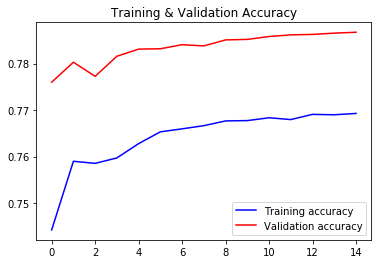

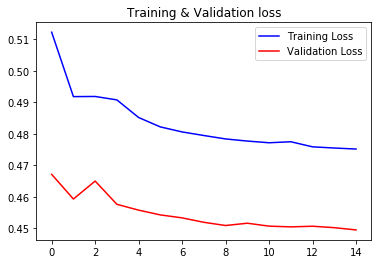

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training & Validation loss')
plt.legend()
 
plt.show()

In [0]:
print(acc)